In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
from google.colab import drive
from matplotlib import pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from PIL import Image
drive.mount('/content/drive')#讀雲端檔案

Mounted at /content/drive


In [ ]:
#將圖片切割pos_num輸入是0,1,2,3分別對應圖片四角，回傳對應位置切割好的圖片
def image_cut(imgs,pos_num):
  pos_num=pos_num
  if pos_num==0:
    imgs=imgs.crop((0,0,imgs.size[0]/2,imgs.size[1]/2))
  elif pos_num==1:
    imgs=imgs.crop((imgs.size[0]/2,0,imgs.size[0],imgs.size[1]/2))
  elif pos_num==2:
    imgs=imgs.crop((0,imgs.size[1]/2,imgs.size[0]/2,imgs.size[1]))
  elif pos_num==3:
    imgs=imgs.crop((imgs.size[0]/2,imgs.size[1]/2,imgs.size[0],imgs.size[1]))
  else:
    print("xx")
  return imgs 
#將圖片切割後根據輸入黏回，輸入是0,1,2,3分別對應圖片四角，回傳對應位置黏好的圖片
def image_paste(image_result,imgs,pos_num):
  x=int(image_result.size[0]/2)
  y=int(image_result.size[1]/2)
  if pos_num==0:
    image_result.paste(imgs,(0,0))
  elif pos_num==1:
    image_result.paste(imgs,(x,0))
  elif pos_num==2:
    image_result.paste(imgs,(0,y))
  elif pos_num==3:
    image_result.paste(imgs,(x,y))
  else:
    print("xx")
  return image_result

In [ ]:
#建立訓練圖片路徑及圖片標示
puzzle_numpy = np.loadtxt('/content/drive/MyDrive/DL_final/puzzle_train/labels.csv',dtype=str,delimiter=',')
puzzle_labels = list(i for i in puzzle_numpy[:,-1])
puzzle_t_labels = np.zeros((len(puzzle_labels),4))
for i in range(len(puzzle_labels)):
  for j in range(4):
    puzzle_t_labels[i][j] = puzzle_labels[i][j]

puzzle_t_labels = torch.tensor(puzzle_t_labels).to(torch.long)
puzzle_name  = [i + '.jpg' for i in puzzle_numpy[:,0]]
puzzle_path = [os.path.join('/content/drive/MyDrive/DL_final/puzzle_train/train/',i) for i in puzzle_name ]

In [ ]:
#建立驗證圖片路徑及圖片標示
val_numpy = np.loadtxt('/content/drive/MyDrive/DL_final/puzzle_train/val_labels.csv',dtype=str,delimiter=',')
val_labels = list(i for i in val_numpy[:,-1])
val_t_labels = np.zeros((len(val_labels),4))
for i in range(len(val_labels)):
  for j in range(4):
    val_t_labels[i][j] = val_labels[i][j]

val_t_labels = torch.tensor(val_t_labels).to(torch.long)
val_name  = [i + '.jpg' for i in val_numpy[:,0]]
val_path = [os.path.join('/content/drive/MyDrive/DL_final/puzzle_train/validation/',i) for i in val_name ]

In [ ]:
#計算mean、std
preporecess_shape = transforms.Compose([transforms.Resize([200,200]),transforms.ToTensor()])
imgs=torch.stack([preporecess_shape(Image.open(puzzle_path[i])) for i in range(len(puzzle_path))],dim=3)
m = imgs.view(3,-1).mean(dim=1)
s = imgs.view(3,-1).std(dim=1)
print(imgs.shape)
print(m)
print(s)
mm = [round(i,3) for i in m.tolist()]#[0.5624, 0.5470, 0.5120]
ss = [round(i,3) for i in s.tolist()]#[0.2945, 0.2836, 0.3154]

torch.Size([3, 200, 200, 1000])
tensor([0.5624, 0.5470, 0.5120])
tensor([0.2945, 0.2836, 0.3154])


In [ ]:
#前處理調整大小、轉換成張量、正規化
preprocess = transforms.Compose([transforms.Resize([100,100]),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mm,std=ss)])
def default_loader(path):
  img_pil = Image.open(path)
  img_pil0 = image_cut(img_pil,0)
  img_pil1 = image_cut(img_pil,1)
  img_pil2 = image_cut(img_pil,2)
  img_pil3 = image_cut(img_pil,3)
  img_tensor  = torch.stack((preprocess(img_pil0),preprocess(img_pil1),preprocess(img_pil2),preprocess(img_pil3)))
  return img_tensor
class TrainSet(Dataset):
  def __init__(self, loader=default_loader):
    self.images = puzzle_path#路徑、轉換
    self.target = puzzle_t_labels
    self.loader = loader
  def __getitem__(self, index):
    fn = self.images[index]#讀檔、前處理、回傳圖片、標籤
    img = self.loader(fn)
    target = self.target[index]
    return img,target
  def __len__(self):
    return len(self.images)
class ValidationSet(Dataset):
  def __init__(self, loader=default_loader):
    self.images = val_path#路徑、轉換
    self.target = val_t_labels
    self.loader = loader
  def __getitem__(self, index):
    fn = self.images[index]#讀檔、前處理、回傳圖片、標籤
    img = self.loader(fn)
    target = self.target[index]
    return img,target
  def __len__(self):
    return len(self.images)

In [ ]:
#建立函數式API
class Net(nn.Module):
    def __init__(self,n_channel=50):
        super().__init__()
        self.n_channel=n_channel
        self.pad2d0 = nn.ZeroPad2d(2)
        self.conv1 = nn.Conv2d(3,50,kernel_size=5,stride=2,padding=2)
        self.conv1_batchnorm = nn.BatchNorm2d(50)

        self.conv2 = nn.Conv2d(50,n_channel*2,kernel_size=5,stride=2,padding=2)
        self.conv2_batchnorm = nn.BatchNorm2d(100)
        self.conv2_dropout = nn.Dropout2d(p=0.3)

        self.conv3 = nn.Conv2d(n_channel*2,n_channel*2,kernel_size=3,stride=2,padding=1)
        self.conv3_batchnorm = nn.BatchNorm2d(100)
        self.conv3_dropout = nn.Dropout2d(p=0.3)

        self.conv4 = nn.Conv2d(n_channel*2,n_channel*4,kernel_size=3,padding=1)
        self.conv4_batchnorm = nn.BatchNorm2d(200)
        self.conv4_dropout = nn.Dropout2d(p=0.3)

        
        self.fc1 = nn.Linear(7*7*4 * n_channel*4, 600)
        self.fc2 = nn.Linear(600, 400)
        self.fc2_dropout = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(400,16)
        #self.SM = nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        x_reshaped = x.view(-1, 3,100,100)

        out = self.pad2d0(x_reshaped)
        out = F.max_pool2d(self.conv1_batchnorm(torch.relu(self.conv1(out))),2)

        out = self.conv2_batchnorm(torch.relu(self.conv2(out)))
        out = self.conv2_dropout(out)

        out = self.conv3_batchnorm(torch.relu(self.conv3(out)))
        out = self.conv3_dropout(out)

        out = self.conv4_batchnorm(torch.relu(self.conv4(out)))
        out = self.conv4_dropout(out)

        out = out.contiguous().view(x.size(0),-1,200,7,7)   
        out = out.view(-1, 7*7*4 * 200) 
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = self.fc2_dropout(out)
        out = self.fc3(out)
        out = out.view(-1,4,4)
        return out

In [ ]:
train_data = TrainSet()
val_data = ValidationSet()
batch_size=64
#train_size = int(len(train_dataset)*0.8)
#val_size = len(train_dataset)-train_size
#print(val_size)
#train_data, val_data = torch.utils.data.random_split(train_dataset,[train_size, val_size])
#print(len(train_dataset))
print(len(train_data))
print(len(val_data))
trainloader = DataLoader(train_data,batch_size,shuffle=True)
valloader = DataLoader(val_data,batch_size,shuffle=True)

1000
100


In [ ]:
#建立訓練迴圈、計算loss、accuracy
import datetime
def tranining_loop(n_epochs,optimizer,model,loss_fn,train_loader,val_loader):
  train_loss_list = [];train_accuracy_list = [];val_loss_list = [];val_accuracy_list = []
  for epoch in range(1,n_epochs+1):
    loss_train = 0.0
    total_train = 0.0
    correct_train = 0.0
    model.train()
    for imgs, labels in train_loader:
      outputs = model(imgs)#每次取出一批次資料未入模型中
      loss = loss_fn(outputs, labels)#計算損失 def image_cut(imgs,pos_num):


      optimizer.zero_grad()#將上一輪的梯度清除
      loss.backward()#反向運行一次，以便取得損失對所有可訓練參數的梯度
      optimizer.step()#更新模型參數
      loss_train += loss.item()#將此次訓練週期中的所有損加總起來

      _,predicted = torch.max(outputs,dim=1)
      correct_train += int((((predicted==labels).sum(1))==4).sum())
      total_train += labels.shape[0]#計算一共有多少樣本

    train_loss_list.append(loss_train/len(train_loader))
    train_accuracy_list.append(correct_train/total_train)

    loss_val = 0.0
    total_val = 0.0
    correct_val = 0.0
    model.eval()
    for imgs, labels in val_loader:
      outputs = model(imgs)#每次取出一批次資料未入模型中
      loss = loss_fn(outputs, labels)#計算損失 def image_cut(imgs,pos_num):
      loss_val += loss.item()

      _,predicted = torch.max(outputs,dim=1)
      correct_val += int((((predicted==labels).sum(1))==4).sum())
      total_val += labels.shape[0]

    val_loss_list.append(loss_val/len(val_loader))
    val_accuracy_list.append(correct_val/total_val)

    if epoch % 1 == 0 or epoch == 10:
      print('{} Epoch {}, Traning loss {:.6f}, Traning acc {:.6f}, Val loss {:.6f}, val acc {:.6f}'.format(datetime.datetime.now(),epoch,loss_train/len(train_loader),correct_train/total_train,loss_val/len(val_loader),correct_val/total_val))
  return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [ ]:
model = Net()#建立模型
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)#隨機梯度下降優化器
loss_fn = nn.CrossEntropyLoss()#交叉商損失函數
n_epochs = 100
train_loss_list,train_accuracy_list,val_loss_list,val_accuracy_list=tranining_loop(n_epochs,
               optimizer=optimizer,
               model=model,
               loss_fn=loss_fn,
               train_loader=trainloader,
               val_loader=valloader)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


2023-01-12 07:04:14.782967 Epoch 1, Traning loss 1.394182, Traning acc 0.002000, Val loss 1.384486, val acc 0.000000
2023-01-12 07:04:59.699286 Epoch 2, Traning loss 1.382778, Traning acc 0.005000, Val loss 1.380146, val acc 0.000000
2023-01-12 07:05:44.454328 Epoch 3, Traning loss 1.369835, Traning acc 0.010000, Val loss 1.373003, val acc 0.000000
2023-01-12 07:06:32.714953 Epoch 4, Traning loss 1.363766, Traning acc 0.006000, Val loss 1.364194, val acc 0.010000
2023-01-12 07:07:17.763462 Epoch 5, Traning loss 1.345929, Traning acc 0.022000, Val loss 1.358741, val acc 0.020000
2023-01-12 07:08:02.417993 Epoch 6, Traning loss 1.333307, Traning acc 0.034000, Val loss 1.351993, val acc 0.040000
2023-01-12 07:08:49.567501 Epoch 7, Traning loss 1.320828, Traning acc 0.034000, Val loss 1.338677, val acc 0.060000
2023-01-12 07:09:34.480597 Epoch 8, Traning loss 1.301614, Traning acc 0.075000, Val loss 1.318996, val acc 0.060000
2023-01-12 07:10:19.619156 Epoch 9, Traning loss 1.278221, Trani

0.39


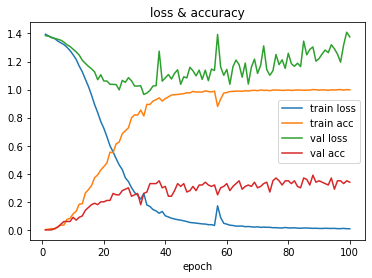

In [ ]:
epoch = np.arange(1,n_epochs+1)
print(max(val_accuracy_list))
plt.plot(epoch,train_loss_list,label="train loss")
plt.plot(epoch,train_accuracy_list,label="train acc")
plt.plot(epoch,val_loss_list,label="val loss")
plt.plot(epoch,val_accuracy_list,label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.title("loss & accuracy")
plt.savefig('1000s_b64.png')
plt.show()

In [ ]:
#torch.save(model.state_dict(),'1000b32.pt')